In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import copy
import pandas as pd
import time

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from utils.subspace_clustering_helper_funcs import *
from utils.preprocessing import *

- https://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold

# Loading in the data
## EMG and IMU

In [2]:
#file_path_kai = 'C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\Filtered_Datasets\\metadata_IMU_EMG_allgestures_allusers.pkl'
file_path_brc = 'D:\\Kai_MetaGestureClustering_24\\saved_datasets\\Filtered_Datasets\\metadata_IMU_EMG_allgestures_allusers.pkl'
#file_path_ben = "C:\\Users\\rubin\\Research\\metadata_IMU_EMG_allgestures_allusers.pkl"

print("Loading")
start_time = time.time()
data_df = pd.read_pickle(file_path_brc)
end_time = time.time()
print(f"Completed in {end_time - start_time}s")

Loading
Completed in 0.10513687133789062s


In [3]:
print(data_df.shape)
data_df.head()

(204800, 91)


,Participant,Gesture_ID,Gesture_Num,IMU1_ax,IMU1_ay,IMU1_az,IMU1_vx,IMU1_vy,IMU1_vz,IMU2_ax,...,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,0.341797,-0.939941,0.000977,-0.007450,-0.192625,0.005321,-0.380859,...,0.000002,0.000002,0.000003,0.000020,0.000004,0.000004,0.000002,0.000009,0.000001,0.000002
1,P102,pan,1,0.336178,-0.963185,0.003898,0.009595,-0.190446,-0.026116,-0.394547,...,0.000003,0.000003,0.000003,0.000014,0.000007,0.000007,0.000002,0.000017,0.000001,0.000002
2,P102,pan,1,0.353539,-0.963704,0.011711,0.095966,-0.205480,-0.155563,-0.398406,...,0.000003,0.000003,0.000004,0.000007,0.000004,0.000005,0.000003,0.000020,0.000003,0.000002
3,P102,pan,1,0.352841,-0.950288,0.011509,0.058836,-0.184871,-0.083567,-0.389230,...,0.000003,0.000003,0.000006,0.000005,0.000004,0.000003,0.000004,0.000015,0.000003,0.000003
4,P102,pan,1,0.372621,-0.991273,0.029847,0.293946,-0.178756,-0.281361,-0.396043,...,0.000003,0.000002,0.000008,0.000003,0.000007,0.000022,0.000004,0.000017,0.000002,0.000003


In [4]:
# Count NaNs in each column
nan_counts_per_column = data_df.isna().sum()
print("Number of NaNs in each column:\n", nan_counts_per_column)

# Count NaNs in each row
nan_counts_per_row = data_df.isna().sum(axis=1)
print("\nNumber of NaNs in each row:\n", nan_counts_per_row)

Number of NaNs in each column:
 Participant    0
Gesture_ID     0
Gesture_Num    0
IMU1_ax        0
IMU1_ay        0
              ..
EMG12          0
EMG13          0
EMG14          0
EMG15          0
EMG16          0
Length: 91, dtype: int64

Number of NaNs in each row:
 0         0
1         0
2         0
3         0
4         0
         ..
204795    0
204796    0
204797    0
204798    0
204799    0
Length: 204800, dtype: int64


In [5]:
data_df["Gesture_ID"].unique()

array(['pan', 'duplicate', 'zoom-out', 'zoom-in', 'move', 'rotate',
       'select-single', 'delete', 'close', 'open'], dtype=object)

In [6]:
data_only_df = data_df.iloc[:,3:]
print(data_only_df.shape)
data_only_df.head()

(204800, 88)


,IMU1_ax,IMU1_ay,IMU1_az,IMU1_vx,IMU1_vy,IMU1_vz,IMU2_ax,IMU2_ay,IMU2_az,IMU2_vx,...,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,0.341797,-0.939941,0.000977,-0.007450,-0.192625,0.005321,-0.380859,-0.888184,-0.334961,0.124514,...,0.000002,0.000002,0.000003,0.000020,0.000004,0.000004,0.000002,0.000009,0.000001,0.000002
1,0.336178,-0.963185,0.003898,0.009595,-0.190446,-0.026116,-0.394547,-0.905297,-0.344967,0.144735,...,0.000003,0.000003,0.000003,0.000014,0.000007,0.000007,0.000002,0.000017,0.000001,0.000002
2,0.353539,-0.963704,0.011711,0.095966,-0.205480,-0.155563,-0.398406,-0.905250,-0.343246,0.140630,...,0.000003,0.000003,0.000004,0.000007,0.000004,0.000005,0.000003,0.000020,0.000003,0.000002
3,0.352841,-0.950288,0.011509,0.058836,-0.184871,-0.083567,-0.389230,-0.896252,-0.337100,0.185074,...,0.000003,0.000003,0.000006,0.000005,0.000004,0.000003,0.000004,0.000015,0.000003,0.000003
4,0.372621,-0.991273,0.029847,0.293946,-0.178756,-0.281361,-0.396043,-0.903902,-0.343370,0.189500,...,0.000003,0.000002,0.000008,0.000003,0.000007,0.000022,0.000004,0.000017,0.000002,0.000003


## Mean subtract each column, standardize each gesture

In [7]:
ms_df = preprocess_df_by_gesture(data_only_df, 'MEANSUBTRACTION')
print(ms_df.shape)
ms_df.head()

(204800, 88)


,IMU1_ax,IMU1_ay,IMU1_az,IMU1_vx,IMU1_vy,IMU1_vz,IMU2_ax,IMU2_ay,IMU2_az,IMU2_vx,...,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,-0.154795,-0.207561,-0.276788,0.051098,0.016745,0.024443,0.296552,-0.248091,-0.092122,-0.062305,...,-1.519137e-06,-1.470037e-07,-4.804797e-06,-0.000006,-3.194128e-06,-3.955994e-06,-2.761547e-06,-0.000010,-7.029408e-07,-5.178945e-07
1,-0.160414,-0.230805,-0.273866,0.068143,0.018924,-0.006994,0.282865,-0.265204,-0.102128,-0.042085,...,-6.918069e-07,4.930801e-07,-4.487795e-06,-0.000011,-3.454802e-08,-7.666755e-07,-2.022076e-06,-0.000001,-6.147716e-07,-2.144813e-07
2,-0.143053,-0.231324,-0.266054,0.154514,0.003890,-0.136441,0.279005,-0.265157,-0.100407,-0.046190,...,-3.763653e-07,6.437183e-07,-3.674076e-06,-0.000019,-2.892269e-06,-2.629805e-06,-1.651926e-06,0.000001,6.229549e-07,2.599464e-08
3,-0.143750,-0.217908,-0.266255,0.117384,0.024499,-0.064445,0.288182,-0.256159,-0.094261,-0.001746,...,-3.238861e-07,4.452346e-07,-2.333567e-06,-0.000020,-3.138945e-06,-4.262033e-06,-7.956578e-07,-0.000003,8.054968e-07,1.099523e-06
4,-0.123971,-0.258893,-0.247918,0.352494,0.030614,-0.262239,0.281369,-0.263809,-0.100531,0.002680,...,-2.160070e-08,2.283233e-07,-9.088692e-08,-0.000022,-7.021894e-07,1.475079e-05,-7.793838e-07,-0.000001,-1.959684e-07,9.493486e-07


In [8]:
# The bad version! Standardizes by channel!

standardized_df = preprocess_df_by_gesture(data_only_df, 'STANDARDSCALER')
print(standardized_df.shape)
standardized_df.head()

(204800, 88)


,IMU1_ax,IMU1_ay,IMU1_az,IMU1_vx,IMU1_vy,IMU1_vz,IMU2_ax,IMU2_ay,IMU2_az,IMU2_vx,...,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,-1.062003,-0.858794,-1.280628,0.058372,0.028126,0.053926,1.355325,-0.986643,-0.763317,-0.149342,...,-0.925569,-0.480126,-1.847291,-0.286930,-1.191791,-0.800271,-2.597721,-2.790928,-1.370371,-1.068966
1,-1.100554,-0.954966,-1.267109,0.077843,0.031786,-0.015429,1.292770,-1.054701,-0.846226,-0.100875,...,-0.421499,1.610438,-1.725413,-0.576721,-0.012891,-0.155093,-1.902118,-0.331839,-1.198487,-0.442703
2,-0.981445,-0.957115,-1.230962,0.176508,0.006533,-0.301011,1.275130,-1.054516,-0.831969,-0.110714,...,-0.229309,2.102434,-1.412565,-0.942372,-1.079161,-0.531992,-1.553927,0.324155,1.214440,0.053655
3,-0.986230,-0.901605,-1.231895,0.134093,0.041150,-0.142176,1.317070,-1.018730,-0.781042,-0.004184,...,-0.197335,1.454171,-0.897182,-1.027206,-1.171201,-0.862180,-0.748456,-0.988000,1.570302,2.269483
4,-0.850530,-1.071181,-1.147051,0.402669,0.051421,-0.578542,1.285934,-1.049153,-0.832996,0.006425,...,-0.013161,0.745722,-0.034943,-1.128485,-0.262000,2.983983,-0.733148,-0.332348,-0.382037,1.959513


In [9]:
bad_stand_df = pd.concat([data_df.iloc[:,:3], standardized_df], axis=1)
print(bad_stand_df.shape)
bad_stand_df.head()

(204800, 91)


,Participant,Gesture_ID,Gesture_Num,IMU1_ax,IMU1_ay,IMU1_az,IMU1_vx,IMU1_vy,IMU1_vz,IMU2_ax,...,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,-1.062003,-0.858794,-1.280628,0.058372,0.028126,0.053926,1.355325,...,-0.925569,-0.480126,-1.847291,-0.286930,-1.191791,-0.800271,-2.597721,-2.790928,-1.370371,-1.068966
1,P102,pan,1,-1.100554,-0.954966,-1.267109,0.077843,0.031786,-0.015429,1.292770,...,-0.421499,1.610438,-1.725413,-0.576721,-0.012891,-0.155093,-1.902118,-0.331839,-1.198487,-0.442703
2,P102,pan,1,-0.981445,-0.957115,-1.230962,0.176508,0.006533,-0.301011,1.275130,...,-0.229309,2.102434,-1.412565,-0.942372,-1.079161,-0.531992,-1.553927,0.324155,1.214440,0.053655
3,P102,pan,1,-0.986230,-0.901605,-1.231895,0.134093,0.041150,-0.142176,1.317070,...,-0.197335,1.454171,-0.897182,-1.027206,-1.171201,-0.862180,-0.748456,-0.988000,1.570302,2.269483
4,P102,pan,1,-0.850530,-1.071181,-1.147051,0.402669,0.051421,-0.578542,1.285934,...,-0.013161,0.745722,-0.034943,-1.128485,-0.262000,2.983983,-0.733148,-0.332348,-0.382037,1.959513


In [10]:
standardized_df = preprocess_df_by_gesture(data_only_df, '$B')
print(standardized_df.shape)
standardized_df.head()

(204800, 88)


,IMU1_ax,IMU1_ay,IMU1_az,IMU1_vx,IMU1_vy,IMU1_vz,IMU2_ax,IMU2_ay,IMU2_az,IMU2_vx,...,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,0.697022,-1.916809,0.001991,-0.015192,-0.392817,0.010851,-0.776681,-1.811260,-0.683081,0.253920,...,0.238382,0.235539,0.365594,2.399152,0.499452,0.453046,0.210249,1.075373,0.154299,0.191514
1,0.685563,-1.964210,0.007950,0.019567,-0.388373,-0.053257,-0.804594,-1.846159,-0.703486,0.295155,...,0.337940,0.312564,0.403741,1.706752,0.879664,0.836837,0.299235,2.095634,0.164909,0.228025
2,0.720967,-1.965269,0.023882,0.195702,-0.419032,-0.317237,-0.812465,-1.846064,-0.699977,0.286784,...,0.375899,0.330691,0.501661,0.833096,0.535776,0.612635,0.343777,2.367802,0.313852,0.256963
3,0.719544,-1.937910,0.023471,0.119984,-0.377005,-0.170417,-0.793751,-1.827714,-0.687443,0.377418,...,0.382214,0.306806,0.662973,0.630402,0.506092,0.416219,0.446817,1.823396,0.335819,0.386148
4,0.759880,-2.021489,0.060867,0.599439,-0.364535,-0.573775,-0.807644,-1.843314,-0.700230,0.386444,...,0.418590,0.280704,0.932849,0.388414,0.799322,2.704151,0.448775,2.095422,0.215306,0.368076


Check for NANs...

In [11]:
# Count NaNs in each column
nan_counts_per_column = standardized_df.isna().sum()
print("Number of NaNs in each column:\n", nan_counts_per_column)

# Count NaNs in each row
nan_counts_per_row = standardized_df.isna().sum(axis=1)
print("\nNumber of NaNs in each row:\n", nan_counts_per_row)

Number of NaNs in each column:
 IMU1_ax    0
IMU1_ay    0
IMU1_az    0
IMU1_vx    0
IMU1_vy    0
          ..
EMG12      0
EMG13      0
EMG14      0
EMG15      0
EMG16      0
Length: 88, dtype: int64

Number of NaNs in each row:
 0         0
1         0
2         0
3         0
4         0
         ..
204795    0
204796    0
204797    0
204798    0
204799    0
Length: 204800, dtype: int64


In [12]:
meta_stand_df = pd.concat([data_df.iloc[:,:3], standardized_df], axis=1)
print(meta_stand_df.shape)
meta_stand_df.head()

(204800, 91)


,Participant,Gesture_ID,Gesture_Num,IMU1_ax,IMU1_ay,IMU1_az,IMU1_vx,IMU1_vy,IMU1_vz,IMU2_ax,...,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,0.697022,-1.916809,0.001991,-0.015192,-0.392817,0.010851,-0.776681,...,0.238382,0.235539,0.365594,2.399152,0.499452,0.453046,0.210249,1.075373,0.154299,0.191514
1,P102,pan,1,0.685563,-1.964210,0.007950,0.019567,-0.388373,-0.053257,-0.804594,...,0.337940,0.312564,0.403741,1.706752,0.879664,0.836837,0.299235,2.095634,0.164909,0.228025
2,P102,pan,1,0.720967,-1.965269,0.023882,0.195702,-0.419032,-0.317237,-0.812465,...,0.375899,0.330691,0.501661,0.833096,0.535776,0.612635,0.343777,2.367802,0.313852,0.256963
3,P102,pan,1,0.719544,-1.937910,0.023471,0.119984,-0.377005,-0.170417,-0.793751,...,0.382214,0.306806,0.662973,0.630402,0.506092,0.416219,0.446817,1.823396,0.335819,0.386148
4,P102,pan,1,0.759880,-2.021489,0.060867,0.599439,-0.364535,-0.573775,-0.807644,...,0.418590,0.280704,0.932849,0.388414,0.799322,2.704151,0.448775,2.095422,0.215306,0.368076


## Applying dimensionality reduction algorithms:

In [13]:
#df_t, dim_reduc_model = apply_dim_reduc(X_ms, model_str='PCA', num_dims=40, hp=None, modality=['EMG and IMU'], participant_inclusion=['All'], apply='ALL')
_, dim_reduc_model = apply_dim_reduc(meta_stand_df, model_str='PCA', num_dims=40, use_full_dataset=True)

Start
Success


In [14]:
print(dim_reduc_model.explained_variance_)
print(dim_reduc_model.explained_variance_ratio_)

[5.74424758 4.71177785 2.99559567 2.76414365 2.54835968 2.24855741
 1.86498087 1.70327569 1.58474639 1.51457647 1.4388895  1.2469394
 1.10356225 1.0746862  0.97327994 0.90998464 0.87457798 0.83397457
 0.81469508 0.77037271 0.68336381 0.64751959 0.5761717  0.55794502
 0.51308418 0.47942466 0.40717971 0.39738013 0.3465181  0.30603076
 0.29710037 0.25063863 0.2495878  0.23823478 0.21099703 0.20449797
 0.19574036 0.18971933 0.14815891 0.14038559]
[0.12276604 0.1007001  0.06402186 0.05907527 0.05446354 0.04805616
 0.03985837 0.0364024  0.0338692  0.03236952 0.03075194 0.02664959
 0.02358533 0.02296819 0.02080094 0.01944819 0.01869148 0.0178237
 0.01741166 0.0164644  0.01460485 0.01383879 0.01231394 0.0119244
 0.01096563 0.01024626 0.00870224 0.00849281 0.00740578 0.00654049
 0.00634963 0.00535665 0.00533419 0.00509155 0.00450943 0.00437053
 0.00418336 0.00405468 0.00316645 0.00300032]


## Completely unfunctionalized, just applying on X (data_df minus metadata) directly

## Evaluation
> Eval of dim reduc... probably not that important, just figure out roughly what corresponds to at least 80% of explained variance, and then go straight to clustering

Once these work, combine all of these into the same for loop (eg so that you only apply PCA for all the comps once, and eval all the (working) metrics during that for loop as opposed to redoing PCA every singl time)

In [15]:
dfs = [data_df.iloc[:,3:], bad_stand_df.iloc[:,3:], meta_stand_df.iloc[:,3:]]
df_titles= ["EMG+IMU Dataset", "Old Standardization", "$B Standardization"]

In [16]:
# Maximum number of components
def max_num_components(df, title):
    min_comps = df.shape[1]
    max_comps = df.shape[1]
    # Store explained variances for each number of components
    explained_variances = []
    
    if max_comps < 25:
        components_range = list(range(1, max_comps))
    else:
        # Create a combined range: 1-25, and then every 5th value after 25
        step=5
        components_range = list(range(1, 25)) + list(range(25+step, max_comps + 1, step))
    # Ensure max_comps is included if not already in the list
    if max_comps not in components_range:
        components_range.append(max_comps)
    
    for n in components_range:
        # print(f"{n}/{max_comps}")
        pca = PCA(n_components=n)
        pca.fit(df)
        explained_var = np.sum(pca.explained_variance_ratio_)
        explained_variances.append(explained_var)
        if n <= min_comps and explained_var > .95:
            min_comps = n
    # Plot the cumulative explained variance
    plt.plot(components_range, explained_variances, marker='o')
    plt.axhline(y=0.95, linestyle="--", color='r')
    plt.axhline(y=0.8, linestyle="--", color='r')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance vs Number of Components for '+ title)
    plt.grid(True)
    plt.show()
    print(title + " PCs @ 95% = " + str(min_comps))
    #print(title + " PCs @ 80% = " + str(min_comps))

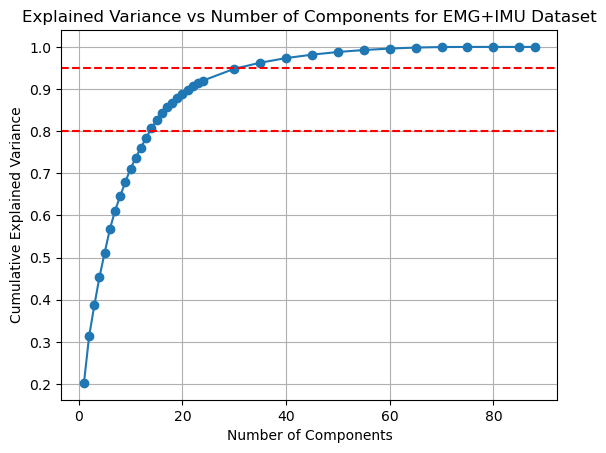

EMG+IMU Dataset PCs @ 95% = 35


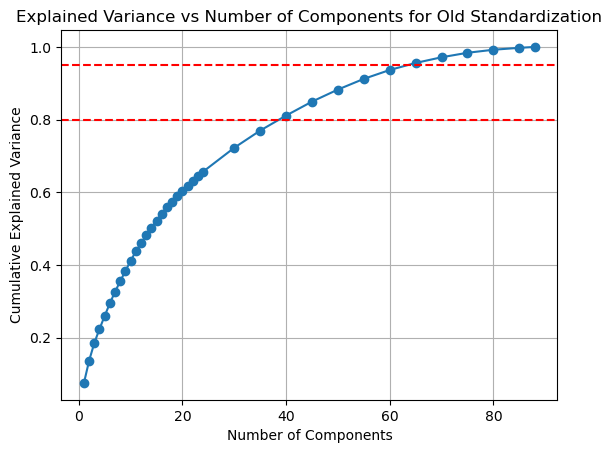

Old Standardization PCs @ 95% = 65


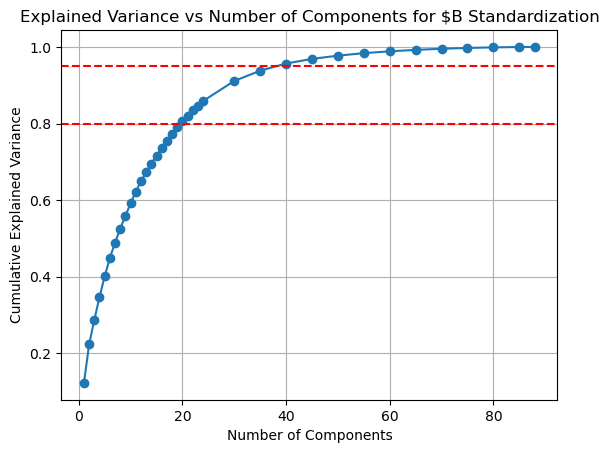

$B Standardization PCs @ 95% = 40


In [17]:
for i in range(3):
    max_num_components(dfs[i], df_titles[i])

In [18]:
## 2. Reconstruction Error and RMSE

from sklearn.metrics import mean_squared_error

def reconstruction_rmse(df, title):
    min_comps = df.shape[1]
    max_comps = df.shape[1]
    if max_comps < 25:
        components_range = list(range(1, max_comps))
    else:
        # Create a combined range: 1-25, and then every 5th value after 25
        step=5
        components_range = list(range(1, 25)) + list(range(25+step, max_comps + 1, step))
    # Ensure max_comps is included if not already in the list
    if max_comps not in components_range:
        components_range.append(max_comps)
    reconstruction_errors = []
    for n in components_range:
        pca = PCA(n_components=n)
        df_reduced = pca.fit_transform(df)
        df_reconstructed = pca.inverse_transform(df_reduced)
        rmse = np.sqrt(mean_squared_error(df, df_reconstructed))
        reconstruction_errors.append(rmse)
        # not sure if .05 is proper benchmark --> It is arbitrary...
        if n <= min_comps and rmse < .05:
            min_comps = n
    
    # Plot the reconstruction error
    plt.plot(components_range, reconstruction_errors, marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Reconstruction RMSE')
    plt.title('Reconstruction Error vs Number of Components '+ title)
    plt.grid(True)
    plt.show()
    print(title+ " minimum number of components = " + str(min_comps))

In [ ]:
for i in range(3):
    reconstruction_rmse(dfs[i], df_titles[i])

## EMG Only

In [ ]:
emg_file_path_kai = 'C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\Filtered_Datasets\\metadata_EMG_allgestures_allusers.pkl'
emg_file_path_brc = 'D:\\Kai_MetaGestureClustering_24\\saved_datasets\\Filtered_Datasets\\metadata_EMG_allgestures_allusers.pkl'
#emg_file_path_ben = "C:\\Users\\rubin\\Research\\metadata_EMG_allgestures_allusers.pkl"

print("Loading")
start_time = time.time()
emg_df = pd.read_pickle(emg_file_path_brc)
end_time = time.time()
print(f"Completed in {end_time - start_time}s")

standardized_emg_df = preprocess_df_by_gesture(emg_df, '$B', biosignal_switch_ix_lst=[])

emg_dfs = [emg_df.iloc[:,3:], standardized_emg_df.iloc[:,3:]]
df_titles= ["EMG Only Data", "Standardized EMG Data"]

In [ ]:
for i in range(3):
    max_num_components(emg_dfs[i], df_titles[i])

In [ ]:
for i in range(3):
    reconstruction_rmse(emg_dfs[i], df_titles[i])

## IMU Only

In [ ]:
imu_file_path_kai = 'C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\Filtered_Datasets\\metadata_IMU_allgestures_allusers.pkl'
imu_file_path_brc = 'D:\\Kai_MetaGestureClustering_24\\saved_datasets\\Filtered_Datasets\\metadata_IMU_allgestures_allusers.pkl'
#imu_file_path_ben = "C:\\Users\\rubin\\Research\\metadata_IMU_allgestures_allusers.pkl"

print("Loading")
start_time = time.time()
imu_df = pd.read_pickle(imu_file_path_brc)
end_time = time.time()
print(f"Completed in {end_time - start_time}s")

standardized_imu_df = preprocess_df_by_gesture(imu_df, '$B', biosignal_switch_ix_lst=[])

imu_dfs = [imu_df.iloc[:,3:], standardized_imu_df.iloc[:,3:]]
df_titles= ["IMU Only Data", "Standardized IMU Data"]

In [ ]:
for i in range(3):
    max_num_components(imu_dfs[i], df_titles[i])

In [ ]:
for i in range(3):
    reconstruction_rmse(imu_dfs[i], df_titles[i])